# First pass image processing for Task 1

This notebook has python code for detecting interesting regions in images for Task 1.  There are two main features we need to locate in the images:

1. The big screen in the middle of the console switches from black to white to signify the task start.  Likewise it goes back to black when the task is over.
2. Detect blue, green., or red LEDS while the task is in progress.

The next step is to port this code to a ROS node that subscribes to camera feeds, processes the images, and publishes the image location when a LED is found.  After that, use the stereo camers to project to a 3D location.

In [1]:
# A bit of setup

import cv2
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

# Raw images

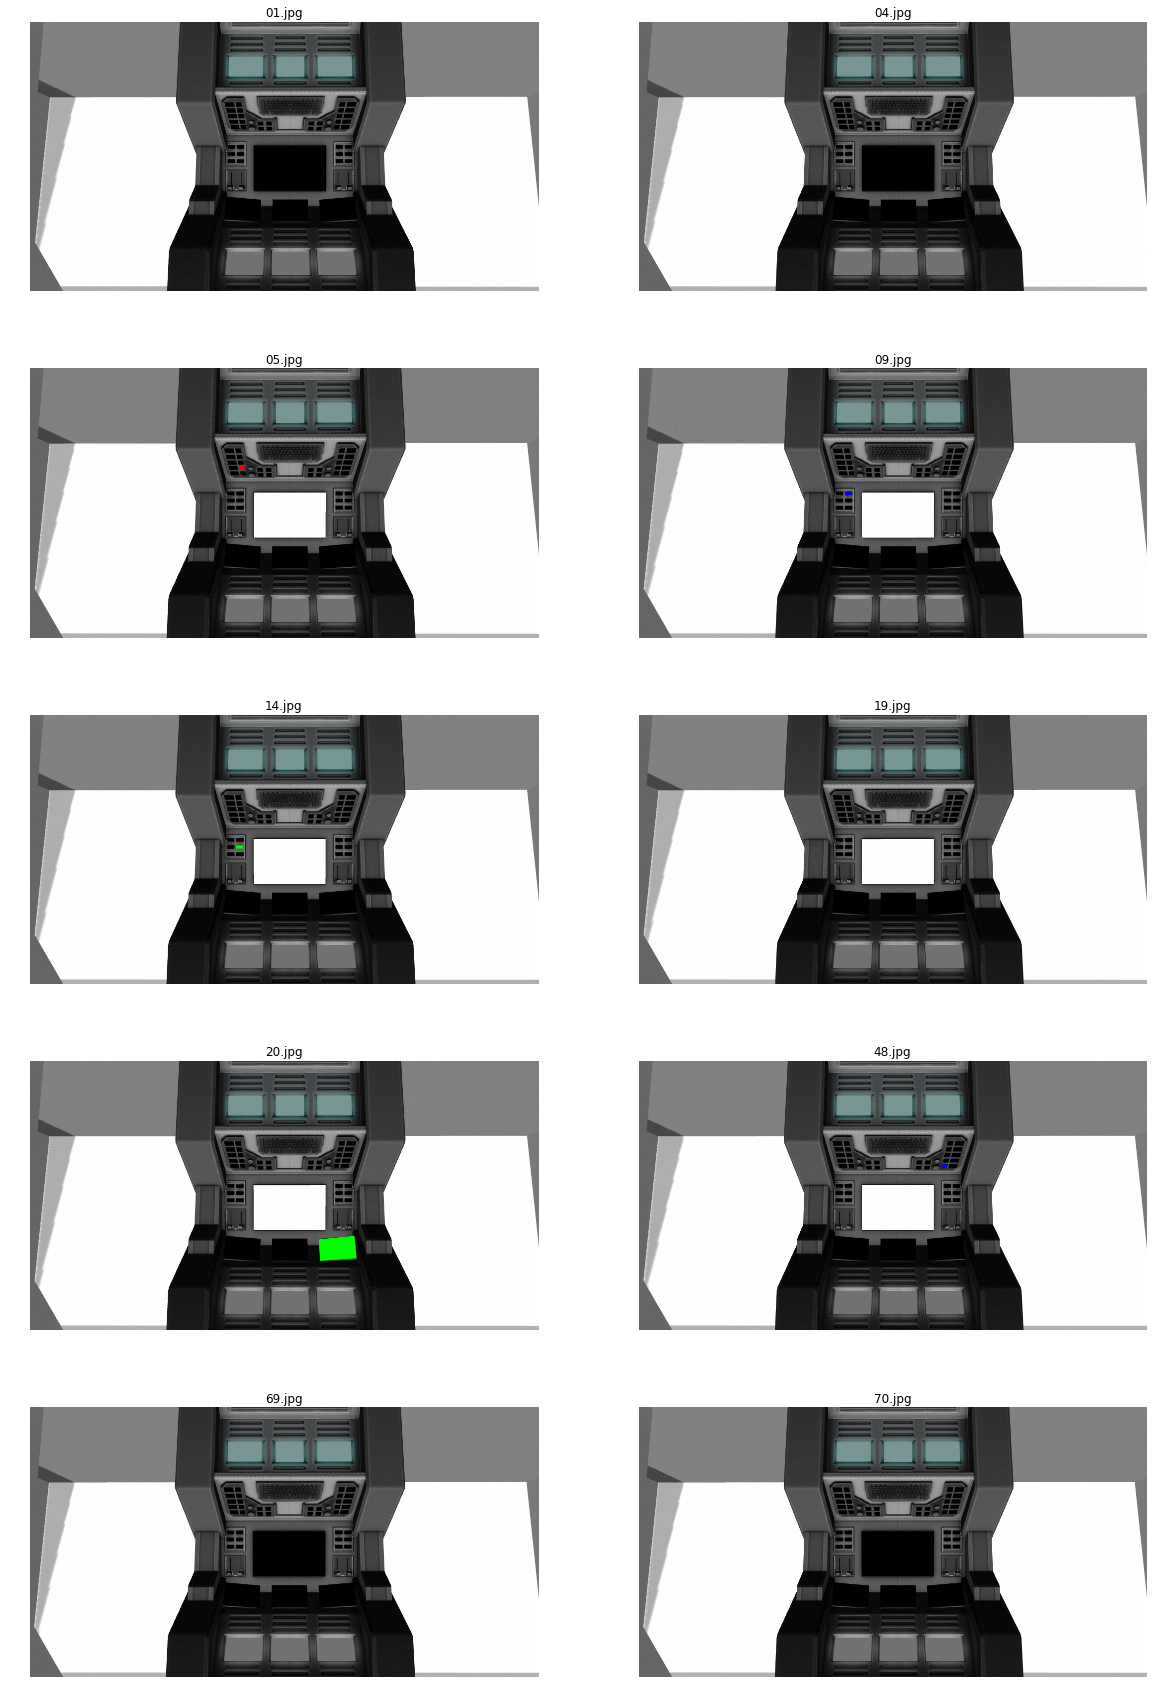

In [2]:
image_nums = [1, 4, 5, 9, 14, 19, 20, 48, 69, 70]
image_dir = '/home/marty/patriot_robotics/task1-dataset1/'

def load_images():
    # Read some images
    images = []
    for num in image_nums:
        filename = image_dir + ('%02d.png' % num)
        images.append((cv2.imread(filename)))
    return images

# plot the raw images
images = load_images()
cols = 2
rows = len(images) / cols
plt.figure(figsize=(20, 30))
for i in range(len(images)):
    plt.subplot(rows, cols, i + 1)
    plt.title("%02d.jpg" % image_nums[i])
    plt.imshow(cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB))
    plt.axis('off')
    
plt.show()

## 1. On/Off detector.

Use gray scale images.  Subtract first image and threshold.  Look for a big white blob covering the middle of the image.

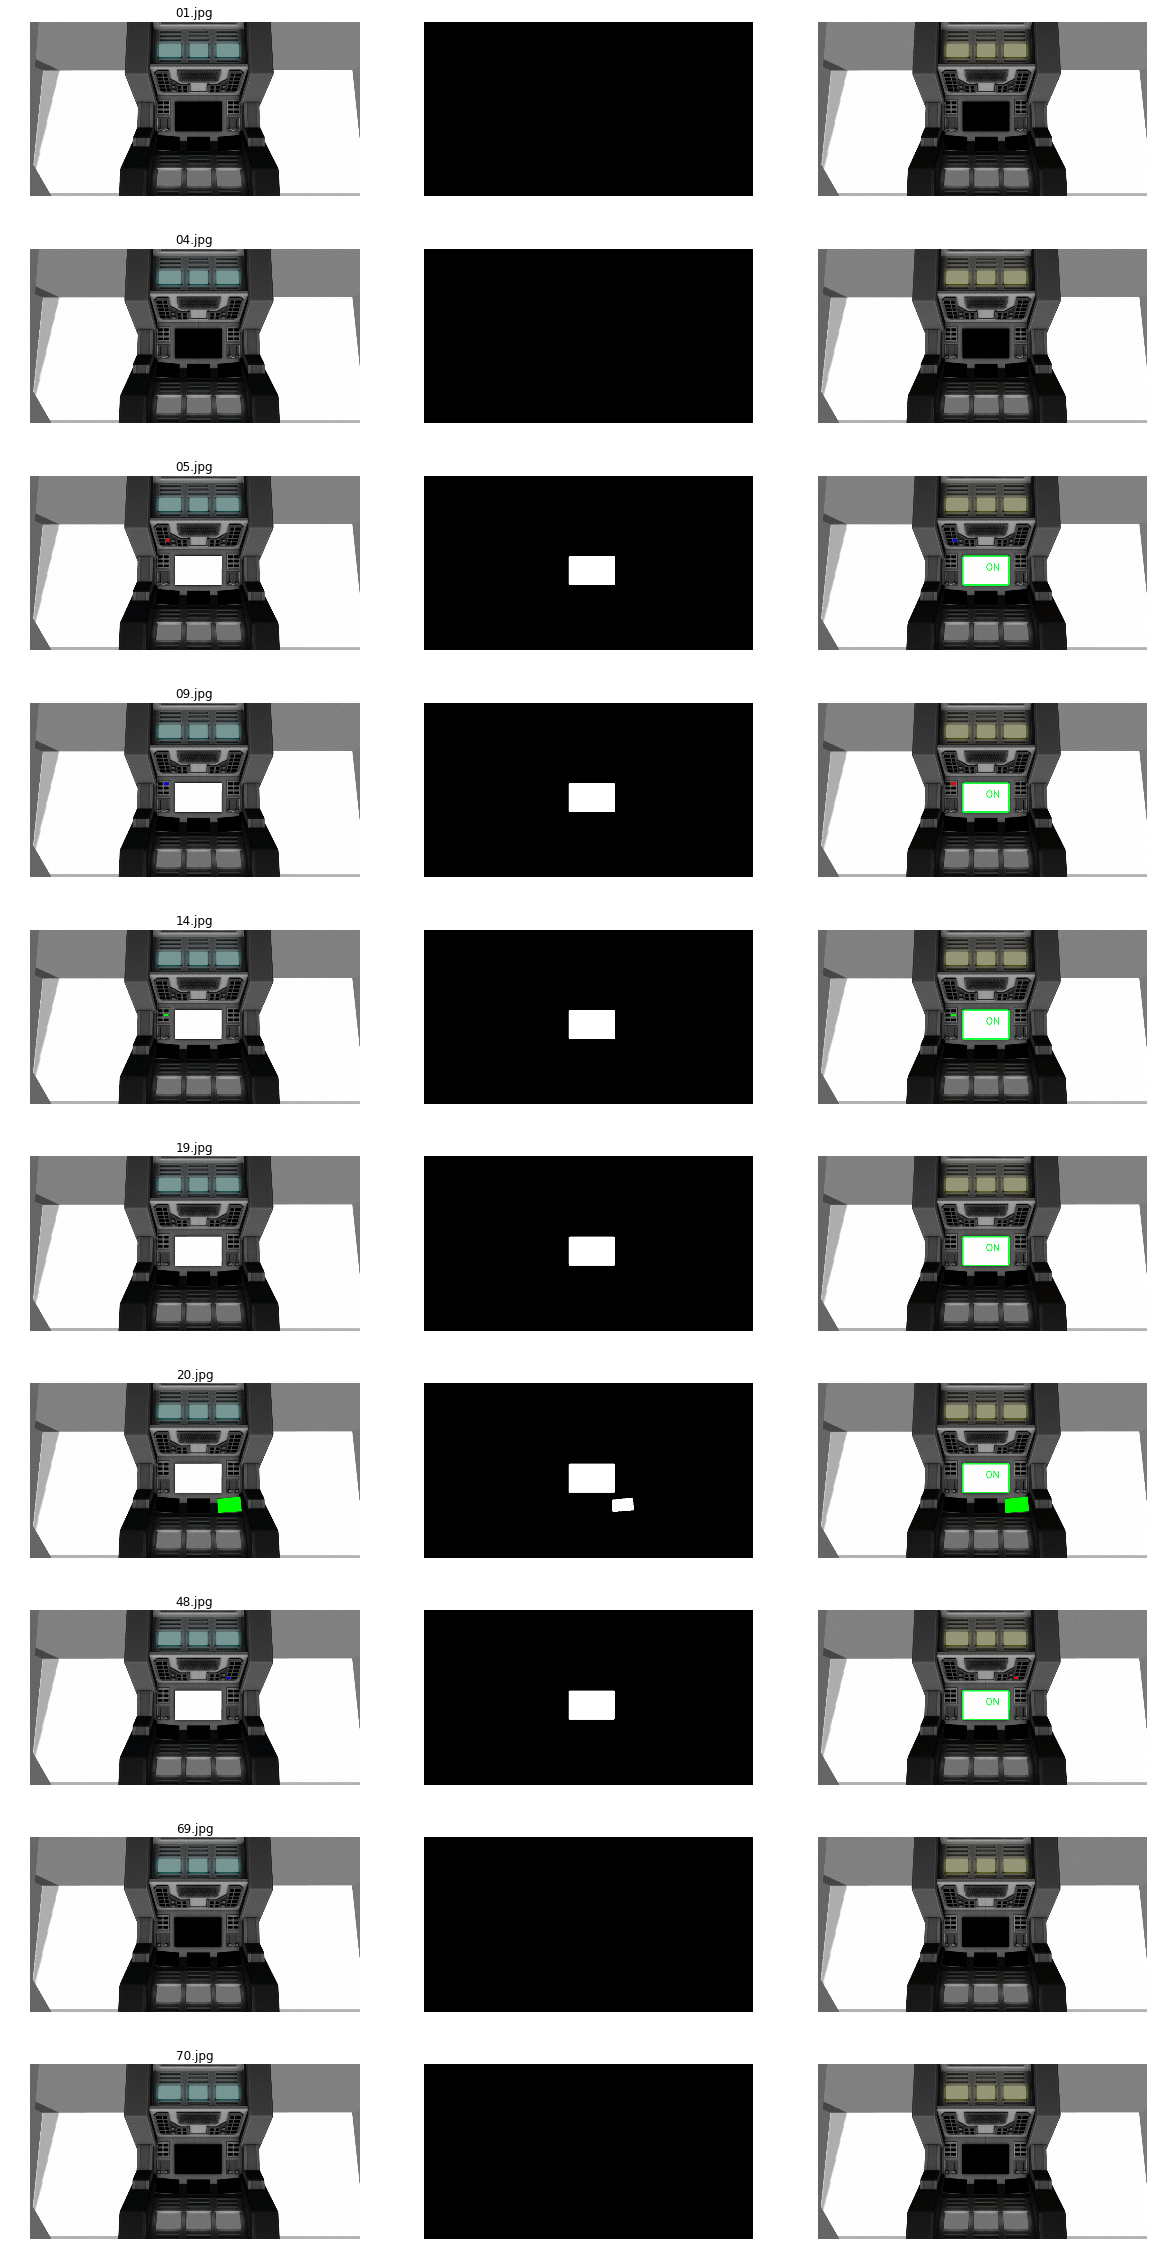

In [5]:
def pre_process(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray, (15, 15), 0)
    return blur

plt.figure(figsize=(20, 40))

images = load_images()
first_image = pre_process(images[0])

rows = len(images)
cols = 3

for i in range(rows):
    
    image_bgr = images[i]
    image = pre_process(image_bgr)
    delta = cv2.absdiff(first_image, image)
    ret, thresh = cv2.threshold(delta, 127, 255, cv2.THRESH_BINARY) 
    contours, hierarchy = cv2.findContours(
        np.copy(thresh), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    image_with_contours = np.copy(image_bgr)

    # If we find a contour which contains the image center, use it
    center = (thresh.shape[1] / 2, thresh.shape[0] / 2)
    for contour in contours:
        location = cv2.pointPolygonTest(contour, center, False)
        if location > -1:
            cv2.drawContours(image_with_contours, [contour], 0, (20, 255, 57), 3)
            M = cv2.moments(contour)
            cx = int(M['m10']/M['m00'])
            cy = int(M['m01']/M['m00'])
            cv2.putText(
                image_with_contours, "ON", (cx, cy), cv2.FONT_HERSHEY_SIMPLEX, 
                1,(20, 255, 57), 2)
            break

    plt.subplot(rows, cols, (i * cols) + 1)
    plt.imshow(cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.title("%02d.jpg" % image_nums[i])

    plt.subplot(rows, cols, (i * cols) + 2)
    plt.imshow(thresh, cmap='gray')
    plt.axis('off')
    
    plt.subplot(rows, cols, (i * cols) + 3)
    plt.imshow(image_with_contours) 
    plt.axis('off')

plt.show()

## 2. LED Detector
Change to HSV color space and look for red, green, and blue blobs.

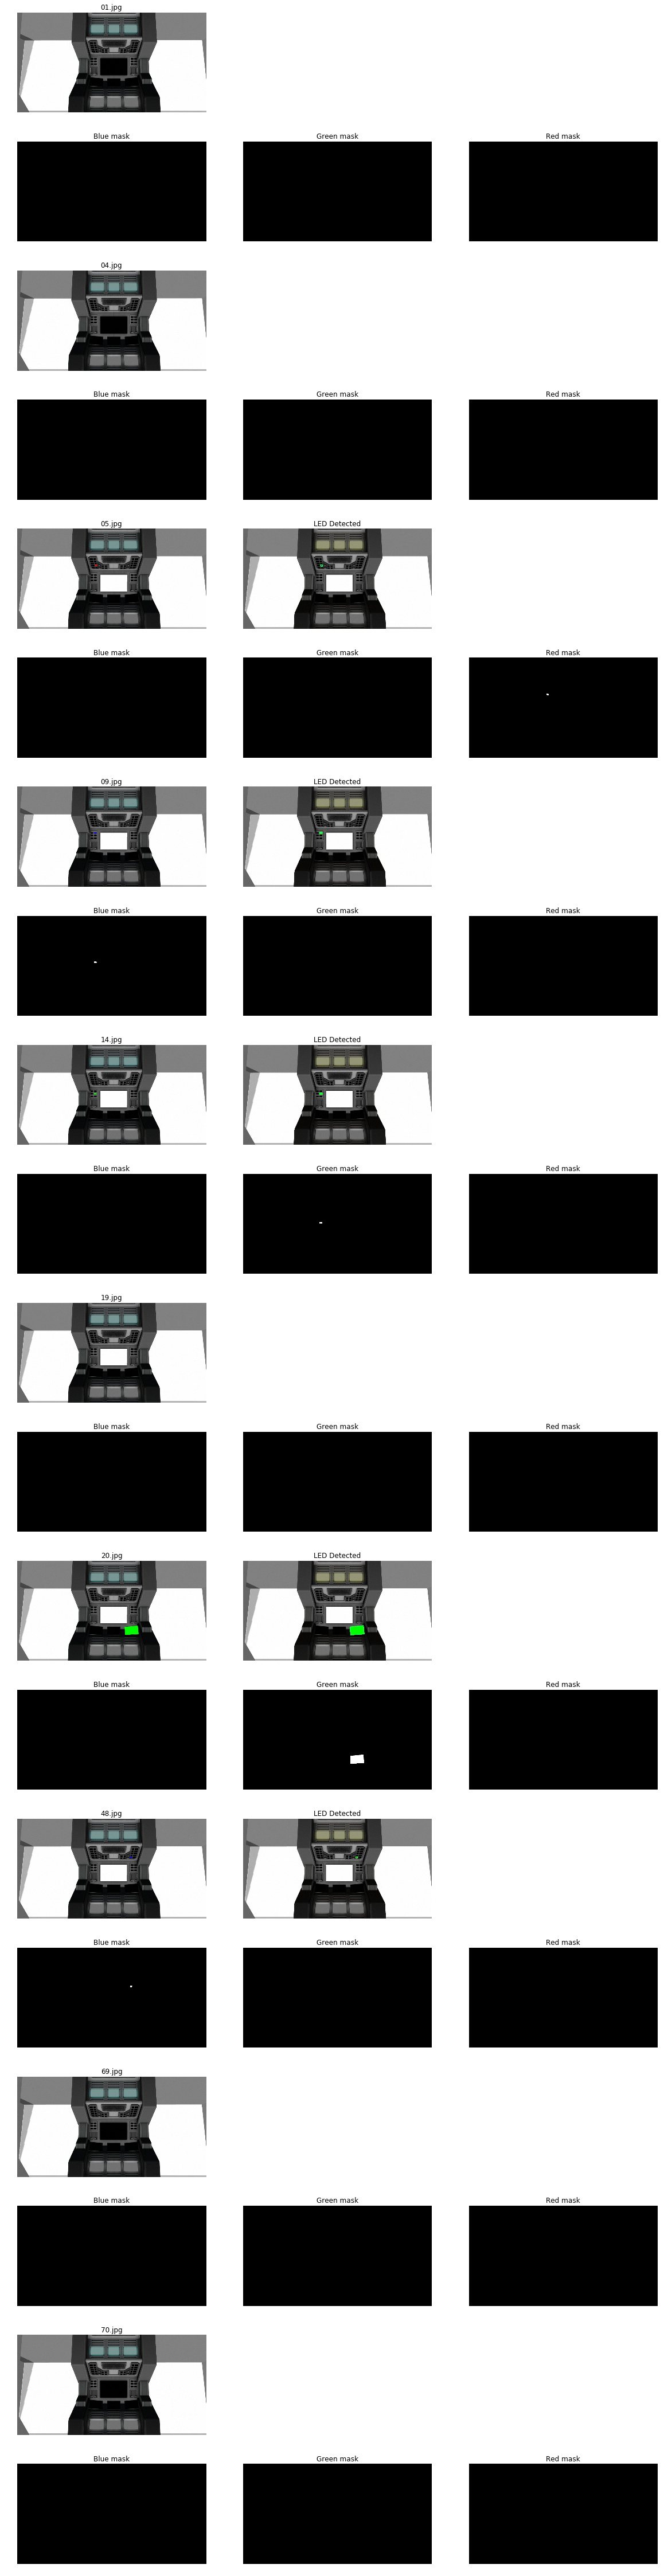

In [6]:
images = load_images()
image_bgr = images[3]

#image_bgr = cv2.imread('/home/marty/Pictures/Webcam/2016-11-12-213927.jpg')
image_bgr = cv2.imread('/home/marty/patriot_robotics/task1-dataset1/09.png')
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
image_hsv = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2HSV)

# mask = cv2.inRange(image_hsv, (119, 127, 127), (121, 255, 255))
# plt.imshow(mask, cmap='gray')
# plt.show()

rows = 2 * len(images)
cols = 3
plt.figure(figsize=(20, 80))

for i in range(len(images)):
    
    image_bgr = images[i]
    image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
    image_hsv = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2HSV)

    blue_mask = cv2.inRange(image_hsv, (119, 127, 127), (121, 255, 255))
    green_mask = cv2.inRange(image_hsv, (59, 127, 127), (61, 255, 255))
    red_mask = cv2.inRange(image_hsv, (0, 127, 127), (1, 255, 255))

    image_with_contours = None
    for mask in (blue_mask, green_mask, red_mask):
        contours, hierarchy = cv2.findContours(
            np.copy(mask), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        if len(contours) > 0:
            image_with_contours = np.copy(image_bgr)
            cv2.drawContours(image_with_contours, contours, 0, (20, 255, 57), 3)
            break

    plt.subplot(rows, cols, i * cols * 2 + 1)
    plt.imshow(image_rgb)
    plt.title("%02d.jpg" % image_nums[i])
    plt.axis('off')
    
    # show location of detected LED is available
    if image_with_contours is not None:
        plt.subplot(rows, cols, i * cols * 2 + 2)
        plt.imshow(image_with_contours)
        plt.title("LED Detected")
        plt.axis('off')
        
    plt.subplot(rows, cols, i * cols * 2 + cols + 1)
    plt.imshow(blue_mask, cmap='gray')
    plt.axis('off')
    plt.title("Blue mask")
    
    plt.subplot(rows, cols, i * cols * 2 + cols + 2)
    plt.imshow(green_mask, cmap='gray')
    plt.axis('off')
    plt.title("Green mask")
    
    plt.subplot(rows, cols, i * cols * 2 + cols + 3)
    plt.imshow(red_mask, cmap='gray')
    plt.axis('off')
    plt.title("Red mask")
    
plt.show()

In [7]:
# find green in OpenCV HSV space

blue = np.uint8([[[255,0,0]]])
print cv2.cvtColor(blue,cv2.COLOR_BGR2HSV)

green = np.uint8([[[0,255,0 ]]])
print  cv2.cvtColor(green,cv2.COLOR_BGR2HSV)

red = np.uint8([[[0,0,255]]])
print cv2.cvtColor(red,cv2.COLOR_BGR2HSV)



[[[120 255 255]]]
[[[ 60 255 255]]]
[[[  0 255 255]]]
